<a href="https://colab.research.google.com/github/amoghgadagi/Kaggle_Notebooks/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('/content/drive/MyDrive/MS Machine Learning and AI/Automatic Ticket Classification- Case Study/complaints.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.

df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print the column names
col_names = df.columns
col_names

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign new column names

df.columns = [re.sub('^_', '', col) for col in df.columns]
df.columns = [re.sub(r'^\bsource\b\.', '', col) for col in df.columns]
new_col_names = df.columns
new_col_names

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [7]:
len(df.index)

78313

In [8]:
df.shape

(78313, 22)

In [9]:
#Assign nan in place of blanks in the complaints column

df['complaint_what_happened'].replace('', np.nan, inplace=True)

In [10]:
#Remove all rows where complaints column is nan

df.dropna(subset=['complaint_what_happened'], inplace=True)


In [11]:
df.shape

(21072, 22)

In [12]:
df.isna().sum()*100/len(df.index)

index                         0.000000
type                          0.000000
id                            0.000000
score                         0.000000
tags                         81.890661
zip_code                     22.043470
complaint_id                  0.000000
issue                         0.000000
date_received                 0.000000
state                         0.678626
consumer_disputed             0.000000
product                       0.000000
company_response              0.000000
company                       0.000000
submitted_via                 0.000000
date_sent_to_company          0.000000
company_public_response      99.990509
sub_product                  10.008542
timely                        0.000000
complaint_what_happened       0.000000
sub_issue                    38.800304
consumer_consent_provided     0.000000
dtype: float64

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean(text):
  #Coverting to lower
  text = text.lower()
  #Removing text in sq brackets
  text = re.sub(r'\[.*?\]','',text)
  #Removing punct.
  text=re.sub(r'[%s]%re.escape(string.punctuation)','',text) 
  #Removing words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)  
  return text  

In [14]:
#Write your function to Lemmatize the texts
def lemma(text):     
        
    # Initialize empty list to store lemmas
    lemma_list = []
    
    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [15]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: clean(x)))
df_clean['lemmatized complaints '] = df_clean.apply(lambda x: lemma(x['complaint_what_happened']), axis=1)
df_clean

,complaint_what_happened,lemmatized complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call cha , my ..."
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yr . I 've h...


In [16]:
#Write your function to extract the POS tags 
from textblob import TextBlob
import nltk
!pip install -U textblob
!python -m textblob.download_corpora
def pos_tag(text):

  # write your code here
  # Creating a textblob object
  text_blob = TextBlob(text)
    
  # extracting words with tags 'NN', joining them and return
  return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['lemmatized complaints ']), axis=1)

# View the dataframe
df_clean.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 636 kB 7.3 MB/s 
  Attempting uninstall: textblob
    Found existing installation: textblob 0.15.3
    Uninstalling textblob-0.15.3:
      Successfully uninstalled textblob-0.15.3


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


,complaint_what_happened,lemmatized complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...


In [17]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(5)

,complaint_what_happened,lemmatized complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




[159, 101, 67, 414, 155, 7, 653, 582, 1159, 51]


Text(0, 0.5, 'No. of Complaints')

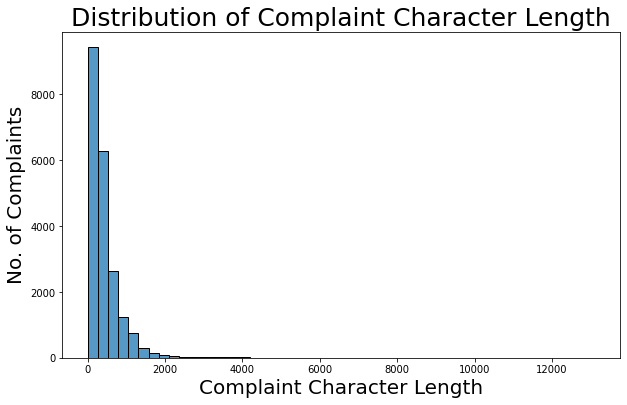

In [18]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len=[len(x) for x in df_clean['complaint_POS_removed']]
print(char_len[:10])
plt.figure(figsize=[10,6])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)

#### Find the top 40 words by frequency among all the articles after processing the text.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


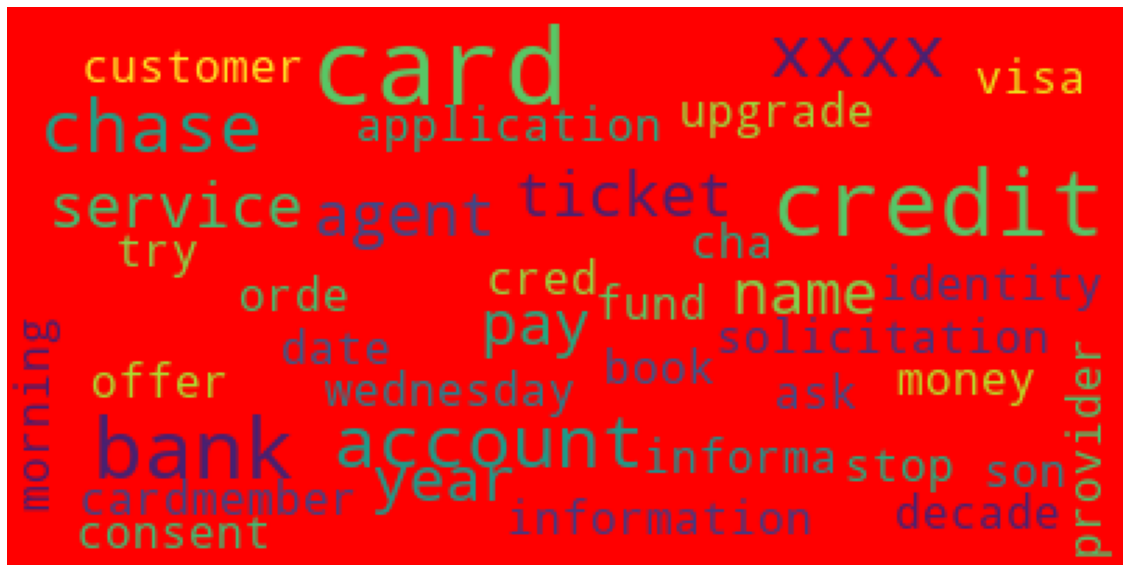

In [21]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
stop_words = set(stopwords.words("english"))
word_cloud = WordCloud(
                          background_color='red',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [22]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [23]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def unigram(text, n=30):
    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [24]:
#Print the top 10 words in the unigram frequency

top_common_words = unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,chase,48952
1,account,47902
2,xxxx,43139
3,credit,34289
4,card,29635
5,bank,28495
6,payment,21336
7,time,16288
8,charge,15150
9,day,13060


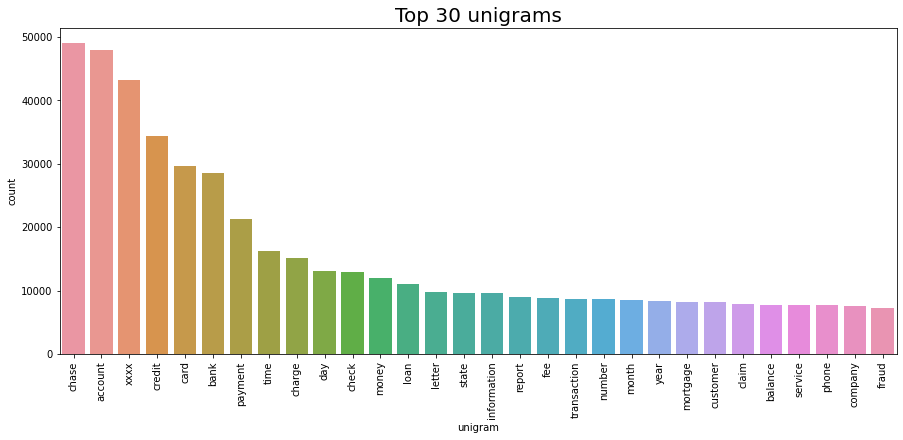

In [25]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df_unigram)
plt.xticks(rotation=90)
plt.title("Top 30 unigrams", fontsize=20)
plt.show()

In [26]:
#Print the top 10 words in the bigram frequency

def bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

top_common_words_bigram = bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words_bigram, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,12878
1,xxxx xxxx,6198
2,credit report,3952
3,customer service,3082
4,chase credit,3061
5,chase bank,2905
6,check account,2884
7,bank account,2763
8,account chase,2737
9,chase account,2441


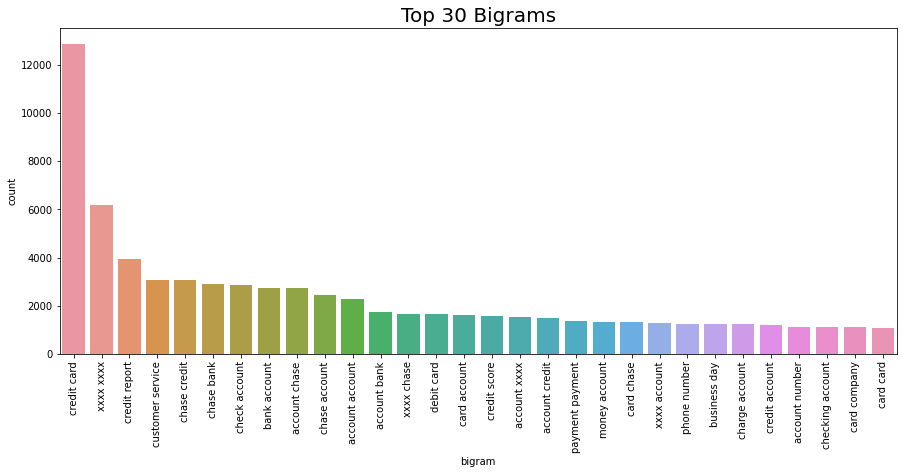

In [27]:
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df_bigram)
plt.xticks(rotation=90)
plt.title("Top 30 Bigrams", fontsize=20)
plt.show()

In [28]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

def trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]


In [29]:
#Print the top 10 words in the trigram frequency

top_common_words_trigram = trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words_bigram, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,credit card,12878
1,xxxx xxxx,6198
2,credit report,3952
3,customer service,3082
4,chase credit,3061
5,chase bank,2905
6,check account,2884
7,bank account,2763
8,account chase,2737
9,chase account,2441


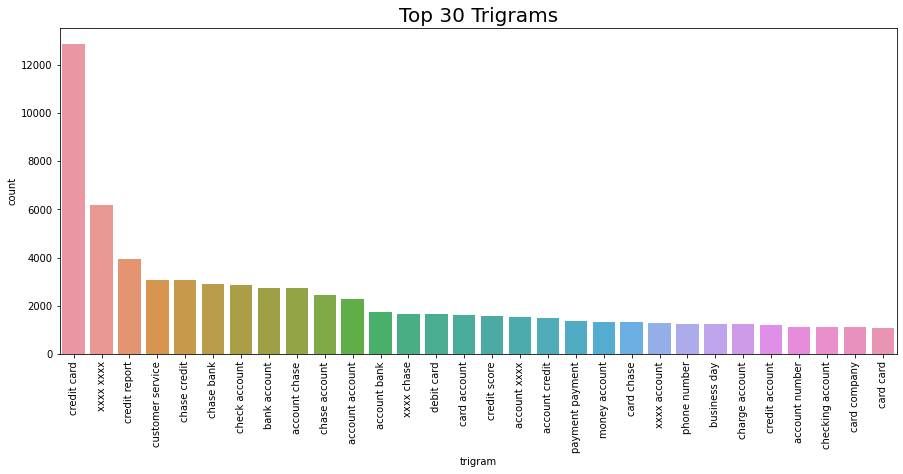

In [30]:
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram)
plt.xticks(rotation=90)
plt.title("Top 30 Trigrams", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [31]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [32]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call cha , my ...",wednesday cha visa credit card provider claim ...,wednesday cha visa credit card provider claim ...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yr . I 've h...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [33]:
df_clean=df_clean.copy()

In [34]:
df_clean.shape

(21072, 4)

In [35]:
#Write your code here to initialise the TfidfVectorizer 

tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [36]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_mat =tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [37]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [38]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5
#write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=5, random_state=40)
#write your code here

In [39]:
nmf_model.fit(doc_term_mat)
len(tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



7117

In [40]:
#Print the Top15 words for each of the topics

for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



TOP 15 WORDS FOR TOPIC #0
['customer', 'transfer', 'transaction', 'number', 'business', 'day', 'branch', 'xxxx', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


TOP 15 WORDS FOR TOPIC #1
['year', 'letter', 'balance', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR TOPIC #2
['foreclosure', 'house', 'bank', 'time', 'document', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'xxxx', 'mortgage', 'loan']


TOP 15 WORDS FOR TOPIC #3
['statement', 'time', 'refund', 'service', 'purchase', 'claim', 'fraud', 'merchant', 'fee', 'dispute', 'transaction', 'chase', 'xxxx', 'card', 'charge']


TOP 15 WORDS FOR TOPIC #4
['mortgage', 'year', 'chase', 'credit', 'account', 'date', 'pay', 'time', 'day', 'auto', 'statement', 'fee', 'month', 'balance', 'payment']




In [41]:
df_clean.shape

(21072, 4)

In [42]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(doc_term_mat)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([0, 3, 1, ..., 3, 4, 4])

In [43]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_result.argmax(axis=1)

In [44]:
df_clean.head()

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,3
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [45]:
df_clean.shape

(21072, 5)

In [46]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')


,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xx...,mishandle account auto xxxx,mishandle account auto,0
17,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,j.p restrict account debit card tuesday branch...,j.p restrict account debit card tuesday branch...,0
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1
26,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,time attempt inquiry creditor place inquiry re...,time attempt inquiry creditor place inquiry re...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [47]:
df_clean.shape

(21072, 5)

In [48]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"
               }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [49]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [50]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4
                }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [51]:
df_clean

,complaint_what_happened,lemmatized complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,3
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call cha , my ...",wednesday cha visa credit card provider claim ...,wednesday cha visa credit card provider claim ...,3
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yr . I 've h...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,4


In [52]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened","Topic"]]

In [53]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,3
10,"chase card was reported on xx/xx/. however, fr...",1
11,"on xx/xx/, while trying to book a xxxx xxxx ...",1
14,my grand son give me check for {$.} i deposit ...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...",3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs. i've had ...,4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [54]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code to get the Vector count

count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [55]:
from sklearn.model_selection import train_test_split
#Lets split into test and train
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")




X_train Shape: (15804, 27984)
y_train Shape: (15804,)
X_test Shape: (5268, 27984)
y_test Shape: (5268,)


## Model 1. Logistic Regression

In [56]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:

model_lr = LogisticRegression(solver='liblinear')
%time 
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [59]:
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.9125327940525975

## Model 2. Decision Tree

In [60]:
# Import required library
from sklearn.tree import DecisionTreeClassifier

In [61]:
# Run Decision Tree with default hyperparameters

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [62]:
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.7755819145244924

## Model 3. Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()

model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

In [64]:
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.807926192641807

As you can see, we have used F1 score as the metrics to decide in the model to be used.

Model decision and inference:
1. Logistic Regression: F1 Score - 0.92
2. Decision Tree: F1 Score - 0.78
3. Random Forest: F1 Score - 0.80

Thus Logistic Regression gives the best results and hence it makes sense to use this model.

Note: The results for each of the models could be improved by hyperparameter tuning, but given the resources we are unable to do so.

